<a href="https://colab.research.google.com/github/abiodunjames/TweetsClassification/blob/master/notebook/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install Libraries
There are python libraries needed for the training. In the block below, I'll install them using pip

* `demoji` is used to remove emojis from tweets. This will be used at the pre-processing step.

In [1]:

!pip install demoji
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
import demoji
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import demoji
from sklearn.utils import shuffle, resample
import math
import spacy
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
import torch.optim as optim
import torch
from spacy.lang.en import English
import nltk
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import time
import json
%matplotlib inline  

In [3]:
demoji.download_codes()
pd.options.display.max_colwidth = 8000

... OK (Got response in 0.12 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK


### Download Datasets

In [4]:
! git clone https://github.com/abiodunjames/TweetsClassification/
! cp -r ./TweetsClassification/data ./data

fatal: destination path 'TweetsClassification' already exists and is not an empty directory.


### Loading data into dataframes

There are multiple files for the tweets. In the cell below we'll read the files and load **them** into dataframes.

In [0]:
diction = spacy.lang.en.stop_words.STOP_WORDS

In [0]:
df = pd.concat([pd.read_csv(f, index_col=False) for f in glob.glob('./data/tweet*.csv')],ignore_index=True, axis=0)

### Data Exploration
 To make sense of the raw datasets, I'll do the following:

 * Read the number of columns
 * Visualize the distribution of spam and non-spam tweets
 * Find the frequencies of words in the spam and non-spam messages 
 * Drop columns not needed for training

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  110527 non-null  int64 
 1   spam        110527 non-null  object
 2   tweet       110527 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.5+ MB


From the info above, there are 110,527 tweets in the datasets.
There are 3 columns: `Unnamed :0`, `tweet` and `spam` column.

In [8]:
# From the info above, we have an `Unnamed:0` column, let's get rid of that
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   spam    110527 non-null  object
 1   tweet   110527 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


In [9]:
df = shuffle(df)
df.head()

,spam,tweet
52575,yes,@ASOS_Julia I foresee a 'The Office' style stationery in the jelly episode...!
2157,yes,grace u suck! U know I know we know....
90433,yes,@backie Happy 4.20. to you to Bakie
69725,yes,@brajana They said I need to floss more. Heh
36736,yes,@alexcovic Isn't the Yugo a classic now? (Classic 'what' I'm not sure of)


In [10]:
# Let's show some basic stastictics
df.describe()

,spam,tweet
count,110527,110527
unique,2,110166
top,yes,The Data Science Capabilities Venn Diagram identifies the key objectives and capabilities for the three key data science roles. Link &gt;&gt; https://t.co/5cvK5co8SS @schmarzo on @DataScienceCtrl ht @bobehayes via @antgrasso #DataScience #DigitalTransformation https://t.co/ZIsB2vsrTZ
freq,99989,23


yes    99989
no     10538
Name: spam, dtype: int64


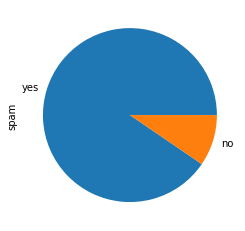

In [11]:
# Let's see how spam/ham we have in the data.
print(df["spam"].value_counts())
df["spam"].value_counts().plot.pie()


### Unbalanced Datasets

Looking at the pie chart above, we have unbalanced datasets which can affect how the model generalizes on unseen data. There are a total of 99,989 Spam and 10,538 Ham, which makes spam to be 10 times larger than Ham. If we use the dataset as it's now, the algorithm learns that a given class is more predominant, making it “natural” to leans towards the predominant class. One way to tackle unbalanced datasets is through **downsampling**

**Downsampling** (in model training context) refers to training on a disproportionately low subset of the majority class sample.

In the block below, we downsample the datasets.


In [0]:
# Select spam and ham
spam = df.loc[df['spam'] == 'yes']
ham = df.loc[df['spam'] =='no']

In [0]:
# Downsampling
spam_downsampled = resample(spam, replace=False, n_samples=10000, random_state=123) #
ham_downsampled = resample(ham, replace=False, n_samples=10000, random_state=123)
datasets = pd.concat([ham_downsampled, spam_downsampled], ignore_index=True)

no     10000
yes    10000
Name: spam, dtype: int64


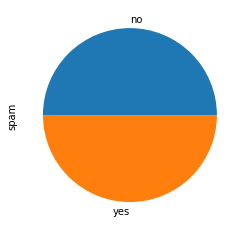

In [14]:
# Plot a pie chart of the downsampled datasets
print(datasets["spam"].value_counts())
datasets["spam"].value_counts().plot.pie()

In [15]:
datasets.head()

,spam,tweet
0,no,Click below to see my weekly #Gold price prediction on the Pynk Beta !! 🙌 Comment below to tell me your prediction... 🧠 CrowdWisdom $XAUUSD $XAU #AI #Fintech #artificialintelligence 🎖️ https://t.co/6wiAB89UR6 via @Pynk_io
1,no,"Are you an aspiring #DataScientist?\nYou have come to the right place.\n#AISciences offers the most updated books on #DataScience, #MachineLearning, #ArtificialIntelligence, and #DeepLearning\nTake your skill sets to the next level!\nLearn more-https://t.co/h8APhHdap6 https://t.co/ZcucOdW9RL"
2,no,"Video: #AI, the end of #deeplearning ?\n#DeepLearning #QuantumMechanics #MachineLearning #CognitiveComputing #RPA #IntelligentAutomation #2AFHD04 https://t.co/ZjP8vcfcBS"
3,no,"Best Cloud VPS Dedicated Server available...\nTo avail such services, connect with us today.\nVisit at &gt;&gt; https://t.co/RdDVh3mHjY #BeSafeGoDigital #StayHome #StaySafe #HellOfABird #HTGAWM #100DaysOfCode #linux #serverless #mlforlife #machineLearning #AI #IoT Dettol https://t.co/m8m8Yb79xD"
4,no,RT @machinelearnflx: Unsupervised Machine Learning Hidden Markov Models in Python https://t.co/Yg3Zj81gHc #machinelearning #ad


In [16]:
# Calculate the mean of the length of tweets
datasets['number_of_words'] = datasets['tweet'].apply(lambda x: len(x.split()))
datasets['tweet_length'] = datasets['tweet'].apply(lambda x: len(x))

print("average number of words: ",np.mean(datasets['number_of_words']))
print("average lenght of tweets: ", np.mean(datasets['tweet_length']))


average number of words:  16.5304
average lenght of tweets:  122.0566


### Data Preprocessing

We have balanced datasets, that is, total number of tweets that are spam are equivalent to the total number of non-spam tweets.

However, the tweets are not clean.  For example:

```
An analog view of a #digital classification #algorithm &gt;&gt;&gt; \nRT @MikeQuindazzi\n\n#AI #MachineLearning #DeepLearning #DataAnalytics #STEM #4IR #DigitalTransformation #EmergingTech #Technology\n\n@mvollmer1\n@evankirstel\n@HeinzVHoenen\n@Fabriziobustama https://t.co/Y3crrNhGZ6
```

The tweets contain usernames, links, emojis, tags, "RT", '-'. These characters don't add meaning to the tweets themselves. They are noises and should be removed.

The function `clean_tweet` below removes noises from a tweet

In [0]:
tok = English()
def clean_tweet(tweet):
        # Remove usernames, "RT" and Hash
        tweet = re.sub(r'(RT|[@*])(\w*)'," ", tweet)
        # Hashtags are very useful. It gives context to the tweet.
        # Remove links in tweets
        tweet = re.sub(r'http\S+', " ", tweet)
        # We remove "#" and keep the tags
        tweet = re.sub(r'(\\n)|(\#)|(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])','', tweet)
        tweet = re.sub(r'(<br\s*/><br\s*/>)|(\-)|(\/)', " ", tweet)
        # convert to lower case
        tweet = re.sub(r"[^a-zA-Z0-9]", " ", tweet.lower()) # Convert to lower case
        # Tweets are usually full of emojis. We need to remove them.
        tweet = demoji.replace(tweet, repl="")
        # Stop words don't meaning to tweets. They can be removed
        tweet_words = tok(tweet)
        clean_tweets = []
        for word in tweet_words:
          if word.is_stop==False and len(word) > 1:
            clean_tweets.append(word.text.strip())

        tweet = " ".join(clean_tweets)
        
        return tweet


In [18]:
datasets['tweet'] = datasets['tweet'].apply(lambda x: clean_tweet(x)) # Clean tweet
shuffle(datasets) # Shuffle datasets
datasets.head()

,spam,tweet,number_of_words,tweet_length
0,no,click weekly gold price prediction pynk beta comment tell prediction crowdwisdom xauusd xau ai fintech artificialintelligence,33,221
1,no,aspiring datascientist come right place aisciences offers updated books datascience machinelearning artificialintelligence deeplearning skill sets level learn,35,288
2,no,video ai end deeplearning deeplearning quantummechanics machinelearning cognitivecomputing rpa intelligentautomation 2afhd04,15,168
3,no,best cloud vps dedicated server available avail services connect today visit gt gt besafegodigital stayhome staysafe hellofabird htgawm 100daysofcode linux serverless mlforlife machinelearning ai iot dettol,32,293
4,no,unsupervised machine learning hidden markov models python machinelearning ad,13,127


### Categorical  Data Encoding
Tweets are categorized as spam or non-spam indicated by `yes` or `no`. Most Machine learning learning models don't do well with strings data. They have to be converted to numeric data. The process of converting categorical data  like `yes` and `no` to numeric data is known as **Encoding**

In the block below, we'll encode categorical variables.

In [19]:
# Encode categorical variables
encoder = LabelEncoder()
spam_encoded = encoder.fit_transform(datasets['spam'])

spam_index_mapping = {index: label for index, label in 
                  enumerate(encoder.classes_)}
print(spam_index_mapping)
# From the block above, we know that 0 means not a spam and 1 means a spam
datasets['label'] = spam_encoded
datasets.head()

{0: 'no', 1: 'yes'}


,spam,tweet,number_of_words,tweet_length,label
0,no,click weekly gold price prediction pynk beta comment tell prediction crowdwisdom xauusd xau ai fintech artificialintelligence,33,221,0
1,no,aspiring datascientist come right place aisciences offers updated books datascience machinelearning artificialintelligence deeplearning skill sets level learn,35,288,0
2,no,video ai end deeplearning deeplearning quantummechanics machinelearning cognitivecomputing rpa intelligentautomation 2afhd04,15,168,0
3,no,best cloud vps dedicated server available avail services connect today visit gt gt besafegodigital stayhome staysafe hellofabird htgawm 100daysofcode linux serverless mlforlife machinelearning ai iot dettol,32,293,0
4,no,unsupervised machine learning hidden markov models python machinelearning ad,13,127,0


In [20]:
# Calculate the mean of the length of tweets
datasets['number_of_words'] = datasets['tweet'].apply(lambda x: len(x.split()))
datasets['tweet_length'] = datasets['tweet'].apply(lambda x: len(x))

print("average number of words: ",np.mean(datasets['number_of_words']))
print("average lenght of tweets: ", np.mean(datasets['tweet_length']))
print("maximum lenght of tweets", np.max(datasets['tweet_length']))

average number of words:  8.99595
average lenght of tweets:  69.39885
maximum lenght of tweets 375


### Text Analytics
 Here, we'll find the frequencies of words in the spam and non-spam in tweets.

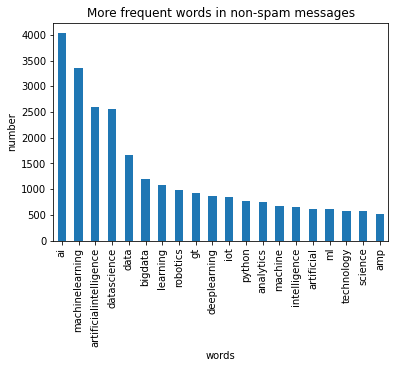

In [21]:
count1 = Counter(" ".join(datasets[datasets['spam']=='no']["tweet"]).split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "words in non-spam", 1 : "count"})

df1.plot.bar(legend = False)
y_pos = np.arange(len(df1["words in non-spam"]))
plt.xticks(y_pos, df1["words in non-spam"])
plt.title('More frequent words in non-spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()


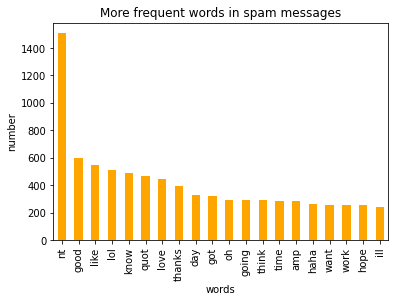

In [22]:
count2 = Counter(" ".join(datasets[datasets['spam']=='yes']["tweet"]).split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "words in spam", 1 : "count_"})
df2.plot.bar(legend = False, color = 'orange')

y_pos = np.arange(len(df2["words in spam"]))
plt.xticks(y_pos, df2["words in spam"])
plt.title('More frequent words in spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

### Feature engineering.
To further preprocess the input data, we need to perform a number of steps such as:
* Tokenization
* Word Stemming
* Sentence encoding

In [0]:
stemmer = SnowballStemmer(language='english')
def stem_tweet(tweet):
  tokenized_tweets = []
  doc = tweet.split() # Tokenize tweet
  for word in doc:
    word = stemmer.stem(word) # Stem word
    tokenized_tweets.append(word)
  return tokenized_tweets

def save_dict(filename, data):
  json.dump(data, open( filename, 'w' ) )


In [24]:
# Testing the `stem_tweet` function
text = 'best practices in mlops production model deployment model monitoring lifecycle management amp governance by with bigdata datascience ai machinelearning analyticsstrategy aistrategy artificialintelligence'
print(stem_tweet(text))

['best', 'practic', 'in', 'mlop', 'product', 'model', 'deploy', 'model', 'monitor', 'lifecycl', 'manag', 'amp', 'govern', 'by', 'with', 'bigdata', 'datasci', 'ai', 'machinelearn', 'analyticsstrategi', 'aistrategi', 'artificialintellig']


In [0]:
# Build a vocabulary dictionary
counts = Counter()
for index, row in datasets.iterrows():
  counts.update(stem_tweet(row['tweet']))


In [26]:
#Return top 10 most common
counts.most_common(20)

[('ai', 4065),
 ('machinelearn', 3370),
 ('artificialintellig', 2602),
 ('datasci', 2582),
 ('robot', 1793),
 ('data', 1689),
 ('nt', 1676),
 ('learn', 1474),
 ('bigdata', 1199),
 ('gt', 1001),
 ('deeplearn', 879),
 ('thank', 854),
 ('iot', 848),
 ('amp', 807),
 ('python', 783),
 ('analyt', 777),
 ('like', 757),
 ('machin', 729),
 ('intellig', 707),
 ('good', 705)]

In [27]:
# Removing infrequent words 
print("num_words before:", len(counts.keys()))

for word in list(counts):
  if(counts[word] < 2):
    del counts[word]
print ("num_words after:", len(counts.keys()))   


num_words before: 20890
num_words after: 9661


In [0]:
# Creat vocabulary list
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]

for word in counts:
  vocab2index[word] = len(words)
  words.append(word)

# Save word_list
save_dict("words.json", words)
save_dict("vocab2index.json", vocab2index)


In [0]:
# According to data exploration I did earlier, the number of characters in tweets average 69
# I'll set the number of characters to be slightly higher. N=75
def encode_sentence(text, vocab2index, N=75):
  tokenized = stem_tweet(text)
  encoded = np.zeros(N, dtype=int)
  enc = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
  length = min(N, len(enc))
  encoded[:length] = enc[:length]
  return encoded, length

In [30]:
datasets['encoded_tweet'] = datasets['tweet'].apply(lambda x: np.array(encode_sentence(x, vocab2index)))
datasets.head()

,spam,tweet,number_of_words,tweet_length,label,encoded_tweet
0,no,click weekly gold price prediction pynk beta comment tell prediction crowdwisdom xauusd xau ai fintech artificialintelligence,16,128,0,"[[2, 3, 4, 5, 6, 7, 8, 9, 10, 6, 11, 12, 13, 14, 15, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 16]"
1,no,aspiring datascientist come right place aisciences offers updated books datascience machinelearning artificialintelligence deeplearning skill sets level learn,17,159,0,"[[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 16, 28, 29, 30, 31, 32, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 17]"
2,no,video ai end deeplearning deeplearning quantummechanics machinelearning cognitivecomputing rpa intelligentautomation 2afhd04,11,124,0,"[[33, 14, 34, 28, 28, 35, 27, 36, 37, 38, 39, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 11]"
3,no,best cloud vps dedicated server available avail services connect today visit gt gt besafegodigital stayhome staysafe hellofabird htgawm 100daysofcode linux serverless mlforlife machinelearning ai iot dettol,26,207,0,"[[40, 41, 42, 43, 44, 45, 45, 46, 47, 48, 49, 50, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 27, 14, 60, 61, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 26]"
4,no,unsupervised machine learning hidden markov models python machinelearning ad,9,78,0,"[[62, 63, 32, 64, 65, 66, 67, 27, 68, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 9]"


In [0]:
# Drop rows whose tweet_length =
tweet_datasets = datasets.loc[datasets['number_of_words'] > 0]
tweet_datasets = tweet_datasets.reset_index()

### Datasets splitting
One of the major challenges in machine learning is overfitting. Overfitting is when a model is so tuned to the training sets that it’s unable to make accurate predictions on data outside of the training sets.

To be prevent overfitting, I'm going to split the datasets into train and test datasets.
A train dataset will be used in learning (fitting the model).

Besides holding out some data for training, I’ll also hold out some independent data for testing. 

60% of the dataset will be used for training and 40% will be used for validation.



In [0]:
X = list(tweet_datasets['encoded_tweet'])
y = list(tweet_datasets['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True)

assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)
assert (len(X_test)+ len(X_train) ==  tweet_datasets['encoded_tweet'].count())



### Creating a custom TweetLoader
 We'll create a custom dataset. This custom dataset will extend Pytorch `Dataset` class

In [0]:
class TweetDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        tweet = torch.from_numpy(self.X[index][0].astype(np.int32))
        label = self.y[index]
        length = self.X[index][1]

        return tweet, label, length
        

In [0]:
train_dataset = TweetDataset(X_train, y_train)
test_dataset = TweetDataset(X_test, y_test)

### Network Architecture
Within the __init__ method, I define the layers of the network module.
There are three layers: an embedding layer, LSTM layer and a linear layer.
The embedding layer is used to transform the sparse encoded vector into a dense embedding vector. 


The linear layer takes the final hidden state and feeds it through a fully connected  layer, transforming it to the correct output dimension.

In [0]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class LSTMClassifier(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        hidden_dim,
        output_dim,
        n_layers,
        bidirectional,
        dropout,
        pad_idx,
        batch_first,
    ):
        """
        Initialize the model by settingg up the various layers.
        """
        super().__init__()

        self.embedding = nn.Embedding(input_dim, embed_dim, padding_idx=pad_idx)
        self.batch_first = batch_first
        self.lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=dropout,
            batch_first=self.batch_first,
        )
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.sig = nn.Sigmoid()

    def forward(self, tweet, length):
        """
        Perform a forward pass of our model on input.
        """
        embeds = self.dropout(self.embedding(tweet))
        # embeds = [batch_size, length, embed dim]
        packed_embeds = pack_padded_sequence(
            embeds, length, batch_first=self.batch_first, enforce_sorted=False
        )

        lstm_out, (hidden, _) = self.lstm(packed_embeds)
        output, output_lengths = pad_packed_sequence(
            lstm_out, batch_first=self.batch_first
        )
        # output = [batch_size, length, hidden_dim * num]
        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        result = self.fc(hidden)

        return self.sig(result)


In [0]:
# vocab2index = {"":0, "UNK":1}

def index2word(tensor):
  """
    It takes a tensor argument and contructs back to a text
  """
  index2word = {index:word for word,index in vocab2index.items()}
  data = tensor.numpy()
  print(data.shape)
  words_list = []
  for row in data:
    for cell in row:
      word = index2word[cell]
      words_list.append(word)

  word = " ".join(words_list)
  print(word)


In [0]:
# Trainable parameters
def count_trainable_params(model):
  """
   Print a string of trainable parameters in a model
  Args:
      model (object): The model object
  """
  n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

  print(f'The model has {n_params} trainable paramters')

In [0]:
# Calculate accuracy
def cal_accuracy(preds, y):
  """
  Returns accuracy per batch. i.e 6 out of 10 means 0.6
  """
  preds = torch.round(preds) # Round prediction up i.e 0.0 and 1.0
  correct = (preds == y)
  correct = correct.float()
  #print(f'correct: {correct.sum()}, wrong {len(correct)}')
  acc = correct.sum()/ len(correct)
  return acc


def convert_pred(y_preds, y_true):
  #y_true = y_true.cpu().detach()
  #y_preds = y_preds.cpu().detach()
  y_preds = torch.round(y_preds) # Round prediction up i.e 0.0 and 1.0  

  return y_preds, y_true


def cal_f1_score(y_pred, y_true):
  """
    Returns an f1 score 
  """
  y_pred, y_true = convert_pred(y_pred, y_true)
  f1 = f1_score(y_pred, y_true)

  return f1

In [0]:

def train(model, train_loader, optimizer, loss_fn, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for batch in train_loader:
      optimizer.zero_grad()
      tweet, label, length = batch
      tweet, length, label = tweet.long(), length.long(), label.float()
      tweet = tweet.to(device)
      label = label.to(device)
      length = length.to(device)
      predictions = model(tweet, length).squeeze(1)  # Outputs is 2 dim Float tensor
      loss = loss_fn(predictions, label)
      acc = cal_accuracy(predictions,label)
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
      epoch_acc += acc.item() 

    return epoch_loss/len(train_loader), epoch_acc/ len(train_loader)

In [0]:
def evaluate_model(model, loader, criterion):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  epoch_loss = 0 
  epoch_acc = 0
  y_preds = None
  y_true = None

  model.eval()
  with torch.no_grad():
    for batch in loader:
      tweet, label, length = batch
      tweet, length, label = tweet.long(), length.long(), label.float()
      tweet = tweet.to(device)
      label = label.to(device)
      length = length.to(device)
      predictions = model(tweet, length).squeeze(1)
      loss = criterion(predictions, label)
      acc = cal_accuracy(predictions ,label)
      pred = torch.round(predictions) # Round up to 0.0, or 1.0
      
      if y_preds == None:
        y_preds = pred
        y_true = label
      else:
        y_preds = torch.cat([y_preds, pred])
        y_true = torch.cat([y_true, label])

      epoch_loss += loss.item()
      epoch_acc += acc.item()

  return epoch_loss/ len(loader), epoch_acc / len(loader), y_preds, y_true

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
train_loss_list = []
valid_loss_list = []

def start_training(model, train_loader, test_loader, optimizer, criterion, epochs=5):
  best_valid_loss = float('inf')
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  # Take advantage of GPU if one is available
  model = model.to(device)
  criterion = criterion.to(device)

  for epoch in range(epochs):
    start_time  = time.time()
    
    train_loss, train_acc = train(model=model, train_loader=train_loader, optimizer=optimizer, loss_fn=criterion, device=device)
    valid_loss, valid_acc, _, _ = evaluate_model(model= model, loader=test_loader,criterion=criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)

    if valid_loss < best_valid_loss:
      best_valid_loss = best_valid_loss
      torch.save(model.state_dict(), 'model.pt')
    print(f'Epoch {epoch+1} | Epoch time: {epoch_mins}:{epoch_secs}s')
    print(f'\t Train Loss : {train_loss:.3f} | Train acc: {train_acc *100:.2f}%')
    print(f'\t Val. Loss : {valid_loss:.3f} | Val acc: {valid_acc *100:.2f}%')
  


### Defining model hyper-

```
# This is formatted as code
```

parametters

In [43]:
print(len(words))

9663


In [0]:
batch_size = 70
embed_dim = 160
hidden_dim = 500
output_dim = (
    len(spam_index_mapping) - 1
) 
input_dim = len(words)
n_layers = 2
bidirectional = True
dropout = 0.5
pad_idx = 1
batch_first = True

lr = 1e-3
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [45]:
model = LSTMClassifier(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    embed_dim=embed_dim,
    output_dim=output_dim,
    bidirectional=bidirectional,
    dropout=dropout,
    n_layers=n_layers,
    pad_idx=pad_idx,
    batch_first=batch_first,
)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.BCELoss()
count_trainable_params(model)
model


The model has 10203081 trainable paramters


LSTMClassifier(
  (embedding): Embedding(9663, 160, padding_idx=1)
  (lstm): LSTM(160, 500, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=1000, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (sig): Sigmoid()
)

### Training the model

In [46]:
start_training(model, train_loader, test_loader , optimizer, loss_fn, epochs=10)

Epoch 1 | Epoch time: 0:17s
	 Train Loss : 0.281 | Train acc: 88.32%
	 Val. Loss : 0.144 | Val acc: 94.95%
Epoch 2 | Epoch time: 0:17s
	 Train Loss : 0.150 | Train acc: 94.58%
	 Val. Loss : 0.116 | Val acc: 96.02%
Epoch 3 | Epoch time: 0:17s
	 Train Loss : 0.120 | Train acc: 95.72%
	 Val. Loss : 0.126 | Val acc: 95.72%
Epoch 4 | Epoch time: 0:17s
	 Train Loss : 0.097 | Train acc: 96.77%
	 Val. Loss : 0.104 | Val acc: 96.37%
Epoch 5 | Epoch time: 0:17s
	 Train Loss : 0.084 | Train acc: 96.97%
	 Val. Loss : 0.099 | Val acc: 96.69%
Epoch 6 | Epoch time: 0:17s
	 Train Loss : 0.075 | Train acc: 97.30%
	 Val. Loss : 0.102 | Val acc: 96.83%
Epoch 7 | Epoch time: 0:17s
	 Train Loss : 0.065 | Train acc: 97.84%
	 Val. Loss : 0.099 | Val acc: 97.03%
Epoch 8 | Epoch time: 0:17s
	 Train Loss : 0.058 | Train acc: 98.05%
	 Val. Loss : 0.092 | Val acc: 97.22%
Epoch 9 | Epoch time: 0:17s
	 Train Loss : 0.043 | Train acc: 98.51%
	 Val. Loss : 0.114 | Val acc: 97.03%
Epoch 10 | Epoch time: 0:17s
	 Train 

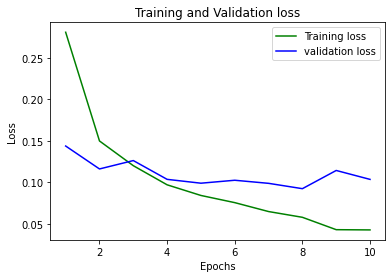

In [47]:
epochs = range(1,11)
plt.plot(epochs, train_loss_list, 'g', label='Training loss')
plt.plot(epochs, valid_loss_list, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Testing the model

In [48]:
model.load_state_dict(torch.load('model.pt'))
test_loss, test_acc, y_preds, y_true = evaluate_model(model, test_loader, loss_fn)
y_true = y_true.cpu().numpy()
y_preds = y_preds.cpu().numpy()

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | F1 Score: {f1_score(y_true, y_preds)} |Recall {recall_score(y_true, y_preds)} | Precision {precision_score(y_true, y_preds)} '  )

Test Loss: 0.103 | Test Acc: 97.29% | F1 Score: 0.9731142643764004 |Recall 0.986872002019692 | Precision 0.959734839184876 


In [49]:
# Archive model artifacts
!zip model_artifacts.zip *.json model.pt

updating: vocab2index.json (deflated 60%)
updating: words.json (deflated 61%)
updating: model.pt (deflated 7%)
